<a href="https://colab.research.google.com/github/emiraydn21/Python/blob/main/Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trial 30 Complete [00h 10m 24s]
val_accuracy: 0.8613333106040955

Best val_accuracy So Far: 0.9045833349227905
Total elapsed time: 01h 30m 31s
conv_1_filter is 16
conv_1_kernel is 3
conv_2_filter is 64
conv_2_kernel is 4
-------------------------------------------------
units is 64
learning_rate is 0.001
dropout is 0.2
Epoch 1/50
1500/1500 [==============================] - 34s 22ms/step - loss: 0.5505 - accuracy: 0.7986 - val_loss: 0.3878 - val_accuracy: 0.8561
Epoch 2/50
1500/1500 [==============================] - 34s 23ms/step - loss: 0.3638 - accuracy: 0.8706 - val_loss: 0.3160 - val_accuracy: 0.8834
Epoch 3/50
1500/1500 [==============================] - 34s 23ms/step - loss: 0.3087 - accuracy: 0.8878 - val_loss: 0.2746 - val_accuracy: 0.8986
Epoch 4/50
1500/1500 [==============================] - 36s 24ms/step - loss: 0.2783 - accuracy: 0.8984 - val_loss: 0.2559 - val_accuracy: 0.9040
Epoch 5/50
1500/1500 [==============================] - 33s 22ms/step - loss: 0.2534 - accuracy

<ipython-input-6-93c0dcfc596d>:129: RuntimeWarning: invalid value encountered in divide
  x /= x.std()


313/313 [==============================] - 2s 7ms/step - loss: 0.2789 - accuracy: 0.9083
[test loss, test accuracy]: [0.2789337635040283, 0.90829998254776]
313/313 [==============================] - 2s 6ms/step
Prediction is -> [ -3.153176  -16.432304  -16.371336  -13.572769  -15.826373    7.673443
 -12.037954    7.1429076   1.0306535   1.6955874]
Actual value is -> 7
The highest value for label is 5


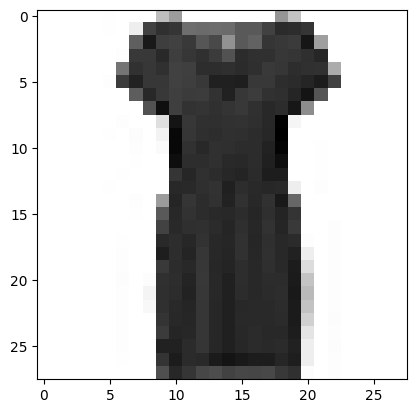

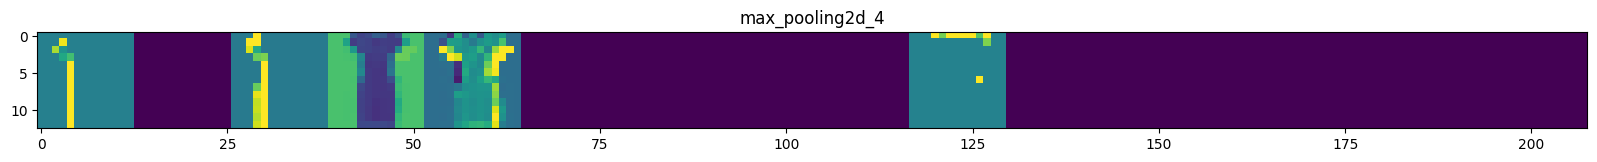

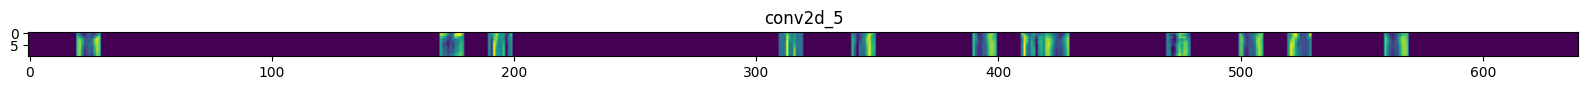

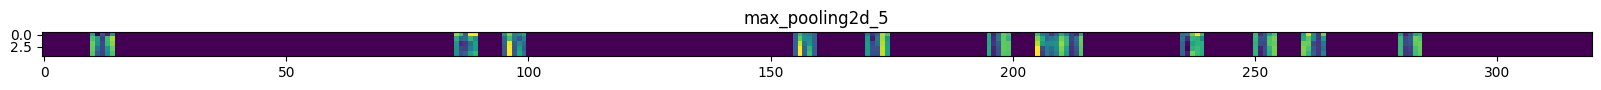

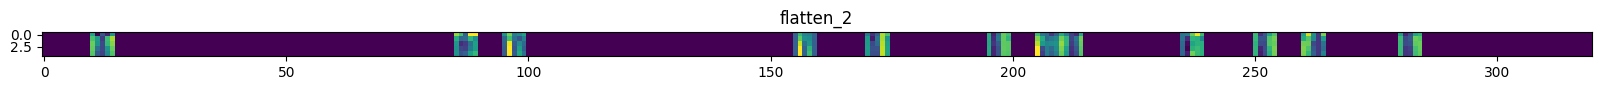

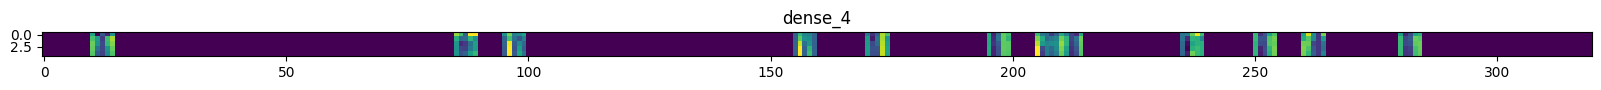

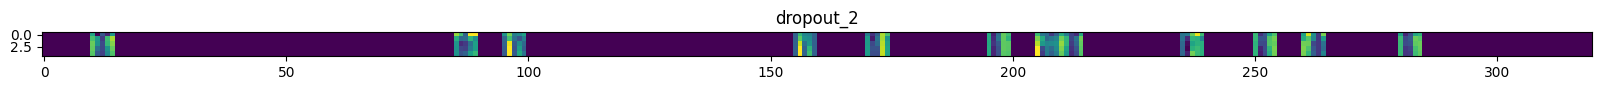

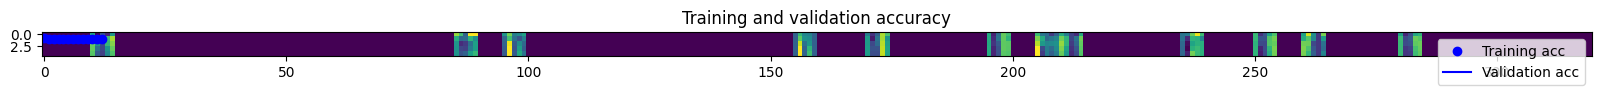

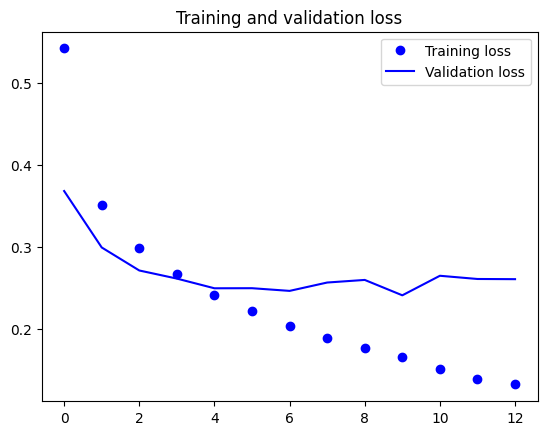

In [6]:
!pip install keras-tuner

import numpy as np
import matplotlib.pyplot as plt
import random

# -----------------------------------
import tensorflow as tf
import keras
from tensorflow import keras
import keras_tuner as kt

fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images  = train_images / 255.0
test_images = test_images / 255.0

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.title("Image label is: {}".format(train_labels[i]))
plt.show()

x_train = train_images.reshape(-1,28,28,1)
x_test = test_images.reshape(-1,28,28,1)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

def build_model(hp):
    model = keras.Sequential([

    # First conv_block
    keras.layers.Conv2D(
        filters = hp.Choice('conv_1_filter', values=[16, 32, 64, 128]),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,4]),
        activation='relu',
        input_shape=(28,28,1)),
    keras.layers.MaxPooling2D((2,2)),

    # Second conv_block
    keras.layers.Conv2D(
        filters = hp.Choice('conv_2_filter', values=[16, 32, 64, 128]),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,4]),
        activation='relu'),
    keras.layers.MaxPooling2D((2,2)),

    # --------------------------------
    keras.layers.Flatten(),
    keras.layers.Dense(units = hp.Choice('units', values=[16, 32, 64, 128, 256]),
                       activation='relu'),
    keras.layers.Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)),

    # --------------------------------
    keras.layers.Dense(10)
    ])

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',
                                                            values=[1e-1, 1e-2, 1e-3, 1e-4])),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

tuner = kt.Hyperband(build_model,
                     objective="val_accuracy",
                     max_epochs=5,
                     factor=3,
                     hyperband_iterations=3)

tuner.search_space_summary()


tuner.search(x_train,train_labels, epochs=3, validation_split=0.2)

best_hps = best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""conv_1_filter is {best_hps.get('conv_1_filter')}""")
print(f"""conv_1_kernel is {best_hps.get('conv_1_kernel')}""")
print(f"""conv_2_filter is {best_hps.get('conv_2_filter')}""")
print(f"""conv_2_kernel is {best_hps.get('conv_2_kernel')}""")
print("-------------------------------------------------")
print(f"""units is {best_hps.get('units')}""")
print(f"""learning_rate is {best_hps.get('learning_rate')}""")
print(f"""dropout is {best_hps.get('dropout')}""")

model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, train_labels,
                    epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

hypermodel = tuner.hypermodel.build(best_hps)

history = hypermodel.fit(x_train, train_labels,
                         epochs=best_epoch,
                         validation_split=0.2,
                         callbacks=[early_stop])


hypermodel.summary()

keras.utils.plot_model(hypermodel, show_shapes=True)


successive_outputs = [layer.output for layer in hypermodel.layers[1:]]
visualization_model = keras.models.Model(inputs = hypermodel.input, outputs = successive_outputs)
index = 20
plt.imshow(train_images[index], cmap=plt.cm.binary)

x = train_images[index]
x = x.reshape((1,) + x.shape)
x /= 255
successive_feature_maps = visualization_model.predict(x)
layer_names = [layer.name for layer in hypermodel.layers[1:]]

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        n_features = feature_map.shape[-1]
        size = feature_map.shape[1]
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x

    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')


eval_result = hypermodel.evaluate(x_test, test_labels)
print("[test loss, test accuracy]:", eval_result)


pred = hypermodel.predict(x_test)

print("Prediction is -> {}".format(pred[12]))
print("Actual value is -> {}".format(test_labels[12]))
print("The highest value for label is {}".format(np.argmax(pred[12])))



import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()